<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/Universal_PyTorch2_AutoTunning_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [487]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [488]:
import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.datamodel import Site, Observation
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday

# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [489]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "state_location":'hawaii',
        "lat":21.446911,
        "lon":-158.188736,
        "elevation":4.0,
        "fresh_data_time":'12',
        "reference_id":"c639b1f3-eb8f-11ed-802e-aec5a60999dc",
        "name":"Waianae, HI Substation",    },
    'or': {
        "state_location":'oregon',
        "lat":45.114559,
        "lon":-123.204903,
        "elevation":50.0,
        "fresh_data_time":'12',
        "reference_id":"5ebb4527-edbd-11ed-bf8d-128dcacebd72",
        "name":"Amity, OR Substation",
    },
    'tx': {
         "state_location":'texas',
        "lat":29.424122,
        "lon":-98.493629,
        "elevation":200.0,
        "fresh_data_time":'06',
        "reference_id":"8568f10f-eb8f-11ed-a556-128dcacebd72",
        "name":"San Antonio, TX Substation",

    },
    'ga': {
        "state_location":'georgia',
        "lat":31.044241,
        "lon":-84.879128,
        "elevation":0.0,
        "fresh_data_time":'06',
        "reference_id":"90c2a42c-f0ad-11ed-94b4-5edf5e2b3336",
        "name":"Donalsonville, GA Substation"
    },

}

tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df

def calculate_reference(start_time, end_time, location):
    def load_data(obs, start_date, end_date):
      return total_data[(total_data.time >= pd.to_datetime(start_date)) & (total_data.time <= pd.to_datetime(end_date))][['time','value']].set_index('time')

    name = states[location]['name']
    latitude = states[location]['lat']
    longitude = states[location]['lon']
    elevation = states[location]['elevation']
    timezone = states[location]['local_time_zone']
    site_id = states[location]['reference_id']
    site = Site(name = name, latitude = latitude, longitude = longitude, elevation = elevation,
                timezone = timezone, site_id = site_id)

    variable = 'net_load'
    interval_value_type = 'interval_mean'
    interval_length = pd.Timedelta(value = 1, unit = 'hour')
    interval_label = 'ending'
    site = site
    uncertainty = 0
    obs = Observation(name = name, variable = variable,
                      interval_value_type = interval_value_type,
                      interval_length = interval_length,
                      interval_label = interval_label,
                      site = site, uncertainty = uncertainty)

    observation  = obs
    forecast_start = pd.to_datetime(start_time + ' 00:00:00')
    forecast_end  = pd.to_datetime(end_time + ' 00:00:00')
    data_start  = forecast_start - pd.Timedelta(value = 30, unit = 'D')
    data_end = forecast_start #- pd.Timedelta(value = 1, unit = 'D')
    interval_length = interval_length
    interval_label = 'ending'
    load_data = load_data
    axis = 'x'
    constant_values = np.array([x for x in range(0,110,10)])


    baseline = persistence_probabilistic_timeofday(observation = obs,
                                        data_start = data_start,
                                        data_end = data_end,
                                        forecast_start = forecast_start,
                                        forecast_end = forecast_end,
                                        interval_length = interval_length,
                                        interval_label = interval_label,
                                        load_data = load_data,
                                        axis = 'y',
                                        constant_values = constant_values)
    baseline = pd.concat(baseline, axis = 1)
    baseline = baseline.reset_index().rename(columns = {'index':'time'}).rename(columns = {i:'p'+str(i*10) for i in range(11)})

    return baseline

# Feature engineering


In [490]:
state_location = 'tx'
training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_historical.csv'.format(states[state_location]['state_location']))
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-03_test.csv'.format(states[state_location]['state_location']))


In [491]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [492]:
test_data.columns

Index(['time', 'value', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'sunset', 'sunrise'],
      dtype='object')

In [493]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [494]:
training_data['hours'] = np.sin((training_data.time.dt.hour - 12) / 24)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

In [495]:
pd.to_datetime('2023-07-03 00:00:00') - pd.Timedelta(2,unit='D')

Timestamp('2023-07-01 00:00:00')

In [496]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)


test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)

In [497]:
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = np.sin((training_data.sunrise.dt.hour + (training_data.sunrise.dt.minute / 60) - 12) / 24)
training_data.sunset = np.sin((training_data.sunset.dt.hour + (training_data.sunset.dt.minute / 60) - 12) / 24)

In [498]:
training_data['month'] = np.sin(training_data.time.dt.month / 12)
test_data['month'] = np.sin(test_data.time.dt.month / 12)

In [499]:
training_data['day'] = np.sin(training_data.time.dt.day / 31)
test_data['day'] = np.sin(test_data.time.dt.day / 31)

In [500]:
pd.to_datetime('2023-07-04 00:00:00') - pd.to_datetime('2023-06-30 00:00:00')
# test_data[test_data.value.isna()]

Timedelta('4 days 00:00:00')

In [501]:
lookback_start = 5
lookback_dim = 12
lookback_end = lookback_dim + lookback_start - 1
for i in range(lookback_start, lookback_end + 1):
  training_data['prev_{}'.format(i)] = training_data.shift(i * 24).value
  test_data['prev_{}'.format(i)] = test_data.shift(i * 24).value



In [502]:
test_data[test_data.value.isna()]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
704,2023-06-30 09:00:00,NaN,27.8,77,23.3,31.2,0.0,100,100,0,...,0.422487,0.426118,0.457181,0.460581,0.429115,0.428942,0.454184,0.451648,0.432227,0.462367
705,2023-06-30 10:00:00,NaN,29.2,73,23.9,32.9,0.0,100,100,0,...,0.452167,0.493545,0.477236,0.485362,0.474873,0.467727,0.470320,0.451014,0.467151,0.471070
706,2023-06-30 11:00:00,NaN,31.6,62,23.4,35.0,0.0,38,29,0,...,0.478504,0.505936,0.517231,0.500230,0.506224,0.505936,0.515099,0.514004,0.490894,0.470263
707,2023-06-30 12:00:00,NaN,32.9,60,24.1,38.9,0.0,40,34,0,...,0.519652,0.533426,0.585523,0.534290,0.578204,0.565353,0.524378,0.553596,0.515387,0.465768
708,2023-06-30 13:00:00,NaN,34.6,51,23.0,40.0,0.0,26,21,0,...,0.562183,0.556535,0.651337,0.603504,0.647879,0.614627,0.553654,0.616183,0.513197,0.498386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,2023-07-05 19:00:00,NaN,33.8,40,18.3,31.7,0.0,44,42,33,...,0.847165,0.891079,0.928308,0.919951,0.830740,0.857480,0.759970,0.878861,0.853101,0.877881
835,2023-07-05 20:00:00,NaN,32.5,44,18.7,31.4,0.0,0,0,0,...,0.840249,0.882722,0.907619,0.896611,0.833333,0.834659,0.757204,0.824631,0.837771,0.903296
836,2023-07-05 21:00:00,NaN,31.3,50,19.6,30.6,0.0,0,0,0,...,0.818061,0.866125,0.873617,0.877536,0.805095,0.801579,0.730290,0.743949,0.792416,0.877132
837,2023-07-05 22:00:00,NaN,29.6,57,20.2,29.4,0.0,0,0,0,...,0.771899,0.823651,0.834371,0.835581,0.760950,0.777835,0.694675,0.703492,0.780947,0.831547


In [503]:
training_data.columns

Index(['time', 'value', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'sunset', 'sunrise', 'hours', 'month', 'day', 'prev_5', 'prev_6',
       'prev_7', 'prev_8', 'prev_9', 'prev_10', 'prev_11', 'prev_12',
       'prev_13', 'prev_14', 'prev_15', 'prev_16'],
      dtype='object')

In [504]:
training_data = training_data[(training_data['prev_'+str(lookback_end)].isna() == False)].reset_index().drop(columns = 'index')

In [505]:
test_data = test_data[(test_data['prev_'+str(lookback_end)].isna() == False)].reset_index().drop(columns = 'index')

In [506]:
# new_df = training_data.drop(columns = 'time')
new_df = training_data[((training_data['time'] <= '2022-10-17 00:00:00') & (training_data['time'] >= '2022-04-15 00:00:00'))].drop(columns = 'time')


In [507]:


val_df = test_data[(test_data.value.isna() == False) ].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [508]:
test_data[(test_data.value.isna() == False) & (test_data.prev_8.isna() == False)]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
0,2023-06-17 01:00:00,0.626844,29.3,80,25.5,34.3,0.0,88,79,88,...,0.518154,0.454933,0.406524,0.382319,0.373271,0.324228,0.396900,0.373963,0.417128,0.405947
1,2023-06-17 02:00:00,0.574112,28.8,83,25.6,35.2,0.0,94,94,37,...,0.482250,0.405256,0.364799,0.340825,0.340422,0.309705,0.374366,0.344283,0.383875,0.358691
2,2023-06-17 03:00:00,0.519767,27.9,87,25.5,33.9,0.0,85,64,85,...,0.441044,0.362379,0.347914,0.314892,0.305037,0.293799,0.347165,0.309763,0.351199,0.335408
3,2023-06-17 04:00:00,0.483287,27.1,93,25.9,33.3,0.0,87,87,0,...,0.412114,0.338405,0.325035,0.319329,0.293568,0.276683,0.321980,0.277317,0.335177,0.341229
4,2023-06-17 05:00:00,0.479772,26.9,88,24.7,32.1,0.0,95,95,0,...,0.405256,0.342958,0.327282,0.304806,0.298525,0.294894,0.313163,0.264408,0.386353,0.379495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2023-06-30 04:00:00,0.459832,27.0,78,22.8,30.1,0.0,100,100,0,...,0.410212,0.416090,0.457527,0.454242,0.481731,0.480233,0.483287,0.453723,0.434993,0.456662
316,2023-06-30 05:00:00,0.440756,27.1,80,23.3,30.7,0.0,100,100,0,...,0.392174,0.410270,0.442312,0.442773,0.454703,0.439661,0.479772,0.466920,0.436549,0.436376
317,2023-06-30 06:00:00,0.457296,27.1,79,23.1,30.6,0.0,94,94,0,...,0.393557,0.420067,0.448536,0.476314,0.436030,0.425945,0.470436,0.459083,0.465537,0.433956
318,2023-06-30 07:00:00,0.449746,26.6,83,23.5,30.8,0.0,100,100,0,...,0.414477,0.406293,0.460120,0.484843,0.422833,0.424504,0.453723,0.466632,0.451245,0.438854


In [509]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

In [510]:
new_df

,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
2110,0.369986,21.2,36,5.6,18.1,0.0,14,6,2,26,...,0.306823,0.322038,0.382146,0.403930,0.411883,0.399666,0.359440,0.321404,0.328435,0.422142
2111,0.328031,20.2,39,5.8,17.5,0.0,14,7,4,16,...,0.289765,0.284751,0.331201,0.380936,0.350968,0.348087,0.319848,0.288266,0.295989,0.337713
2112,0.290168,19.1,48,7.8,17.0,0.0,17,12,2,18,...,0.265964,0.257953,0.301176,0.352006,0.311607,0.306593,0.313566,0.265214,0.266309,0.336849
2113,0.282100,18.8,54,9.3,16.9,0.0,38,25,2,49,...,0.259855,0.251614,0.282907,0.331201,0.297372,0.279852,0.294894,0.251787,0.243603,0.321750
2114,0.276337,18.7,61,11.0,17.5,0.0,85,77,2,50,...,0.247637,0.239627,0.274723,0.321231,0.288151,0.265906,0.271842,0.244871,0.240145,0.309993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6546,0.769882,28.9,43,15.0,29.4,0.0,28,3,30,25,...,0.682630,0.616413,0.576014,0.649608,0.646957,0.623559,0.600450,0.626153,0.610996,0.648283
6547,0.727467,27.9,46,15.1,28.2,0.0,27,2,30,24,...,0.640157,0.592785,0.542070,0.604887,0.610304,0.599412,0.565468,0.597049,0.565410,0.626729
6548,0.663555,27.1,49,15.6,27.4,0.0,50,4,64,27,...,0.607423,0.571865,0.496254,0.550369,0.566332,0.536826,0.520747,0.549620,0.522764,0.595609
6549,0.598432,25.7,58,16.8,26.3,0.0,65,11,79,24,...,0.528873,0.526337,0.461042,0.497176,0.504726,0.469629,0.473317,0.473432,0.489857,0.528469


# Train Val Split

In [511]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [512]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [513]:
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(TrendsModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
    # self.fc2 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.relu = nn.ReLU().to(torch.float64)
    # self.softplus = nn.Softplus().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    # x = self.relu(x)
    # x = self.fc3(x)
    # x = self.relu(x)
    # x = self.fc4(x)
    # x = self.relu(x)
    # x = self.fc5(x)
    # x = self.relu(x)
    # x = self.fc6(x)
    # x = self.relu(x)
    # x = self.fc7(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, lookback_dim, hidden_dim, output_dim, trend_weight = 0.4):
    super(Trend_Feature_model, self).__init__()
    self.trends_model = TrendsModel(lookback_dim, hidden_dim, output_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)
    self.combining_layer = nn.Linear(feature_hidden + hidden_dim, hidden_dim).to(torch.float64)
    self.output_layer = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.trend_weight = trend_weight
    self.lookback_dim = lookback_dim
    self.hidden_dim = hidden_dim
  def forward(self, x):
    x_features = x[:,:-1 * self.lookback_dim]
    x_lookback = x[:,-1 * self.lookback_dim:]
    std_hour = x[:,-self.lookback_dim:].std(dim = 1).view(-1,1)

    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)
    # x = (feature_output * (1 - self.trend_weight)) + (trends_output * self.trend_weight)
    x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    # print(x.shape, self.hidden_dim)
    x = self.combining_layer(x)
    x = self.output_layer(x)
    return x



# Loss Functions

In [514]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,0]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [515]:


class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [516]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - lookback_dim#22  # Specify the input feature dimensions
feature_hidden = 16
lookback_dim = lookback_dim
lookback_hidden = lookback_dim - 2

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            lookback_dim=lookback_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1,
                            trend_weight=0.9)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

            outputs = model(batch_X)
            loss = negLL(outputs, batch_y)
            # loss = mae(outputs, batch_y)
            # loss = crps_loss(outputs, batch_y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/i)
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/150], Train Loss: 0.0032786250056170783, Val Loss: 0.04307253305160973
Epoch [2/150], Train Loss: 0.0027322031616984605, Val Loss: 0.0057433150534286674
Epoch [3/150], Train Loss: 0.0011658385935724863, Val Loss: 0.003462718004530134
Epoch [4/150], Train Loss: 0.000977507748908197, Val Loss: 0.0022550418984331106
Epoch [5/150], Train Loss: 0.0010736126359531264, Val Loss: 0.0016961562160382267
Epoch [6/150], Train Loss: 0.0014579765388818655, Val Loss: 0.0014571779139160846
Epoch [7/150], Train Loss: 0.0012984332629993702, Val Loss: 0.001776943745155489
Epoch [8/150], Train Loss: 0.0010173857085004566, Val Loss: 0.001549058386430674
Epoch [9/150], Train Loss: 0.0010561832964439087, Val Loss: 0.0013501145920692304
Epoch [10/150], Train Loss: 0.0010396539804991458, Val Loss: 0.0018055829971953985
Epoch [11/150], Train Loss: 0.0008969971044771248, Val Loss: 0.0014742814531018842
Epoch [12/150], Train Loss: 0.0011965477650203408, Val Loss: 0.001463526734147649
Epoch [13/150], Trai

In [517]:
# test_data

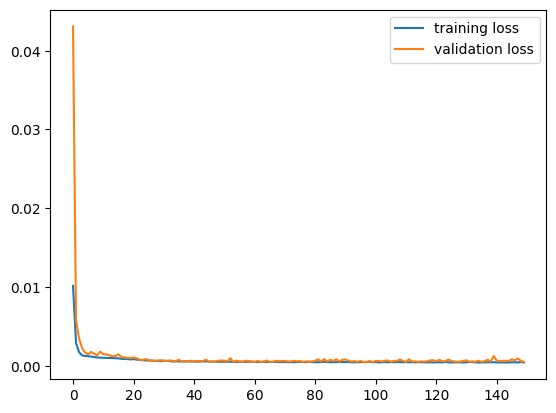

In [518]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [519]:
temp = test_data[(test_data.time >= '2023-06-22 01:00:00') & (test_data.time <= '2023-06-23 00:00:00')].drop(columns = 'time')


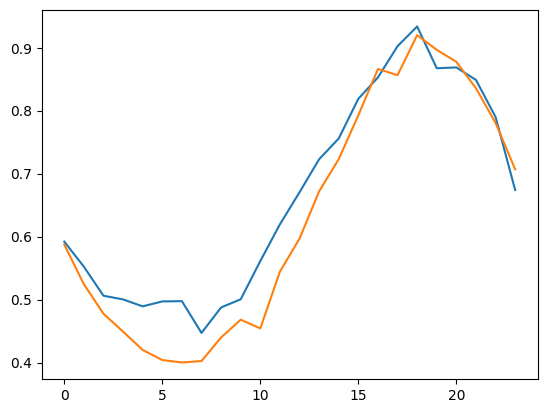

In [520]:
temp = test_data[(test_data.time >= '2023-06-25 01:00:00') & (test_data.time <= '2023-06-26 00:00:00')].drop(columns = 'time')
X_train = temp[[col for col in temp.columns if col != 'value']]
y_train = temp.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


pred = model(X_train)

plt.plot(pred.detach().numpy())
plt.plot(y_train)

In [521]:
test_data[test_data.value.isna() == False]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
0,2023-06-17 01:00:00,0.626844,29.3,80,25.5,34.3,0.0,88,79,88,...,0.518154,0.454933,0.406524,0.382319,0.373271,0.324228,0.396900,0.373963,0.417128,0.405947
1,2023-06-17 02:00:00,0.574112,28.8,83,25.6,35.2,0.0,94,94,37,...,0.482250,0.405256,0.364799,0.340825,0.340422,0.309705,0.374366,0.344283,0.383875,0.358691
2,2023-06-17 03:00:00,0.519767,27.9,87,25.5,33.9,0.0,85,64,85,...,0.441044,0.362379,0.347914,0.314892,0.305037,0.293799,0.347165,0.309763,0.351199,0.335408
3,2023-06-17 04:00:00,0.483287,27.1,93,25.9,33.3,0.0,87,87,0,...,0.412114,0.338405,0.325035,0.319329,0.293568,0.276683,0.321980,0.277317,0.335177,0.341229
4,2023-06-17 05:00:00,0.479772,26.9,88,24.7,32.1,0.0,95,95,0,...,0.405256,0.342958,0.327282,0.304806,0.298525,0.294894,0.313163,0.264408,0.386353,0.379495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2023-06-30 04:00:00,0.459832,27.0,78,22.8,30.1,0.0,100,100,0,...,0.410212,0.416090,0.457527,0.454242,0.481731,0.480233,0.483287,0.453723,0.434993,0.456662
316,2023-06-30 05:00:00,0.440756,27.1,80,23.3,30.7,0.0,100,100,0,...,0.392174,0.410270,0.442312,0.442773,0.454703,0.439661,0.479772,0.466920,0.436549,0.436376
317,2023-06-30 06:00:00,0.457296,27.1,79,23.1,30.6,0.0,94,94,0,...,0.393557,0.420067,0.448536,0.476314,0.436030,0.425945,0.470436,0.459083,0.465537,0.433956
318,2023-06-30 07:00:00,0.449746,26.6,83,23.5,30.8,0.0,100,100,0,...,0.414477,0.406293,0.460120,0.484843,0.422833,0.424504,0.453723,0.466632,0.451245,0.438854


In [522]:
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score

In [523]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

In [524]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
0,2023-06-17 01:00:00,0.626844,29.3,80,25.5,34.3,0.0,88,79,88,...,0.518154,0.454933,0.406524,0.382319,0.373271,0.324228,0.396900,0.373963,0.417128,0.405947
1,2023-06-17 02:00:00,0.574112,28.8,83,25.6,35.2,0.0,94,94,37,...,0.482250,0.405256,0.364799,0.340825,0.340422,0.309705,0.374366,0.344283,0.383875,0.358691
2,2023-06-17 03:00:00,0.519767,27.9,87,25.5,33.9,0.0,85,64,85,...,0.441044,0.362379,0.347914,0.314892,0.305037,0.293799,0.347165,0.309763,0.351199,0.335408
3,2023-06-17 04:00:00,0.483287,27.1,93,25.9,33.3,0.0,87,87,0,...,0.412114,0.338405,0.325035,0.319329,0.293568,0.276683,0.321980,0.277317,0.335177,0.341229
4,2023-06-17 05:00:00,0.479772,26.9,88,24.7,32.1,0.0,95,95,0,...,0.405256,0.342958,0.327282,0.304806,0.298525,0.294894,0.313163,0.264408,0.386353,0.379495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2023-07-05 19:00:00,NaN,33.8,40,18.3,31.7,0.0,44,42,33,...,0.847165,0.891079,0.928308,0.919951,0.830740,0.857480,0.759970,0.878861,0.853101,0.877881
451,2023-07-05 20:00:00,NaN,32.5,44,18.7,31.4,0.0,0,0,0,...,0.840249,0.882722,0.907619,0.896611,0.833333,0.834659,0.757204,0.824631,0.837771,0.903296
452,2023-07-05 21:00:00,NaN,31.3,50,19.6,30.6,0.0,0,0,0,...,0.818061,0.866125,0.873617,0.877536,0.805095,0.801579,0.730290,0.743949,0.792416,0.877132
453,2023-07-05 22:00:00,NaN,29.6,57,20.2,29.4,0.0,0,0,0,...,0.771899,0.823651,0.834371,0.835581,0.760950,0.777835,0.694675,0.703492,0.780947,0.831547


In [525]:
start_date = '2023-06-{:02d}'.format(20 - 1)
end_date = '2023-06-{:02d}'.format(20)
test_df = test_data[(test_data.time >= start_date + ' 01:00:00')
                  & (test_data.time <= end_date + ' 00:00:00')].drop(columns = 'time')


In [526]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
0,2023-06-17 01:00:00,0.626844,29.3,80,25.5,34.3,0.0,88,79,88,...,0.518154,0.454933,0.406524,0.382319,0.373271,0.324228,0.396900,0.373963,0.417128,0.405947
1,2023-06-17 02:00:00,0.574112,28.8,83,25.6,35.2,0.0,94,94,37,...,0.482250,0.405256,0.364799,0.340825,0.340422,0.309705,0.374366,0.344283,0.383875,0.358691
2,2023-06-17 03:00:00,0.519767,27.9,87,25.5,33.9,0.0,85,64,85,...,0.441044,0.362379,0.347914,0.314892,0.305037,0.293799,0.347165,0.309763,0.351199,0.335408
3,2023-06-17 04:00:00,0.483287,27.1,93,25.9,33.3,0.0,87,87,0,...,0.412114,0.338405,0.325035,0.319329,0.293568,0.276683,0.321980,0.277317,0.335177,0.341229
4,2023-06-17 05:00:00,0.479772,26.9,88,24.7,32.1,0.0,95,95,0,...,0.405256,0.342958,0.327282,0.304806,0.298525,0.294894,0.313163,0.264408,0.386353,0.379495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2023-07-05 19:00:00,NaN,33.8,40,18.3,31.7,0.0,44,42,33,...,0.847165,0.891079,0.928308,0.919951,0.830740,0.857480,0.759970,0.878861,0.853101,0.877881
451,2023-07-05 20:00:00,NaN,32.5,44,18.7,31.4,0.0,0,0,0,...,0.840249,0.882722,0.907619,0.896611,0.833333,0.834659,0.757204,0.824631,0.837771,0.903296
452,2023-07-05 21:00:00,NaN,31.3,50,19.6,30.6,0.0,0,0,0,...,0.818061,0.866125,0.873617,0.877536,0.805095,0.801579,0.730290,0.743949,0.792416,0.877132
453,2023-07-05 22:00:00,NaN,29.6,57,20.2,29.4,0.0,0,0,0,...,0.771899,0.823651,0.834371,0.835581,0.760950,0.777835,0.694675,0.703492,0.780947,0.831547


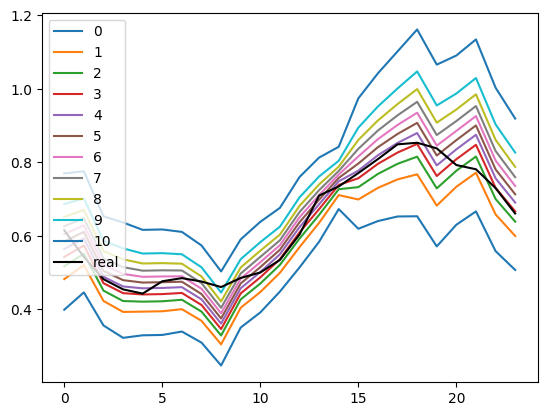

0.027758618914033473 0.7937530098243457


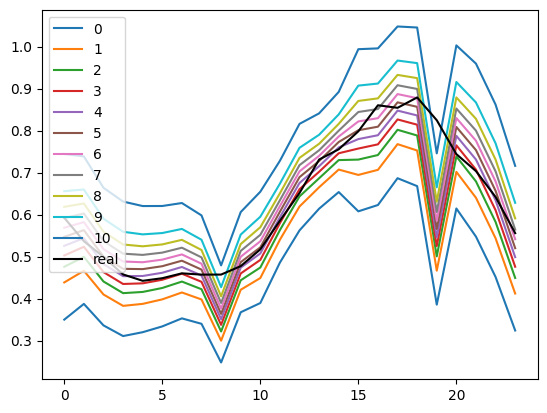

0.031000059709604167 0.7504842024883871


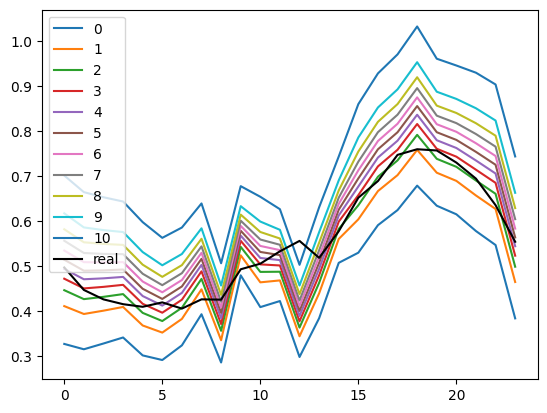

0.03616352023897489 0.38910714183363415


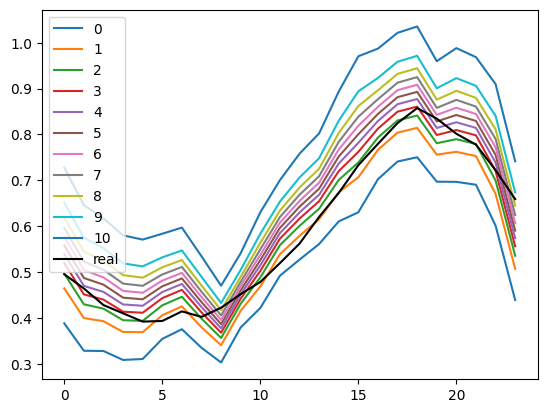

0.03610947734036327 0.3393112894669761


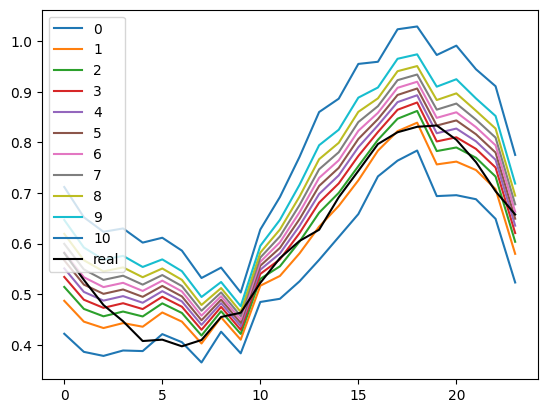

0.036729744664947155 0.3993863385532608


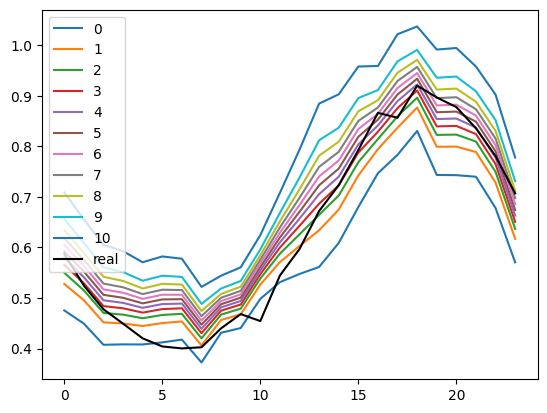

0.032747591152899234 0.596312782733672


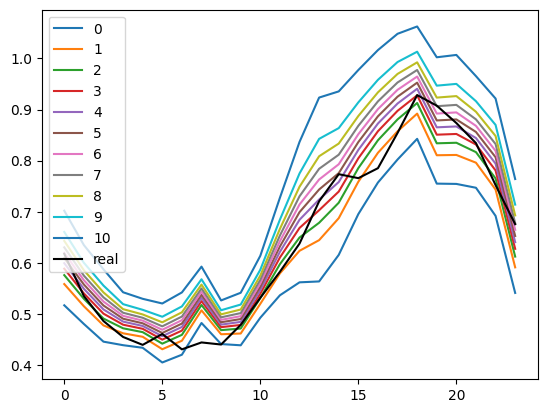

0.027159780028549883 0.7037710164653834


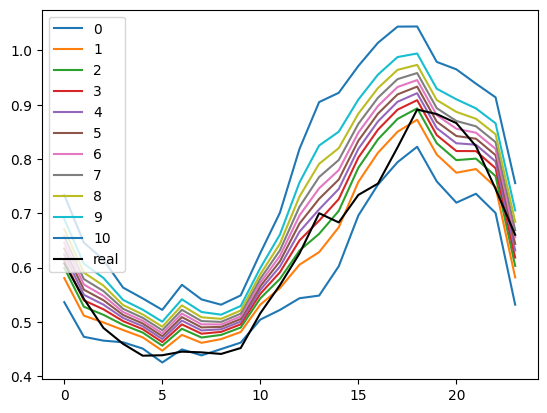

0.03571583631008585 0.5471383649131573


In [527]:
daily_crps = []
daily_crpss = []
for day in range(21, 29):

  start_date = '2023-06-{:02d}'.format(day - 1)
  end_date = '2023-06-{:02d}'.format(day)
  test_df = test_data[(test_data.time >= start_date + ' 01:00:00')
                    & (test_data.time <= end_date + ' 00:00:00')].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)

  # print(preds.shape)
  vals = []
  for i in range(0, 11):
    q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds + (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  for col in weather_cols:
    weather_data = test_df[col].values
    weather_dictionary[col].append(test_df[col].std())


  pred = torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  # submission[['p' + str(i*10) for i in range(11)]] = pred



  obs = y_test.detach().numpy()
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

## CRPSS trend

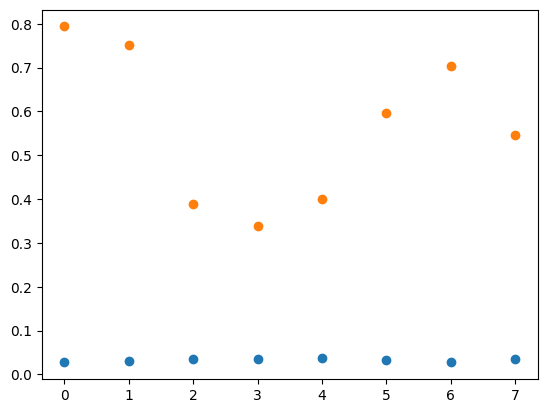

In [528]:
plt.scatter(range(len(daily_crpss)), daily_crps)
plt.scatter(range(len(daily_crpss)), daily_crpss)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


13 13


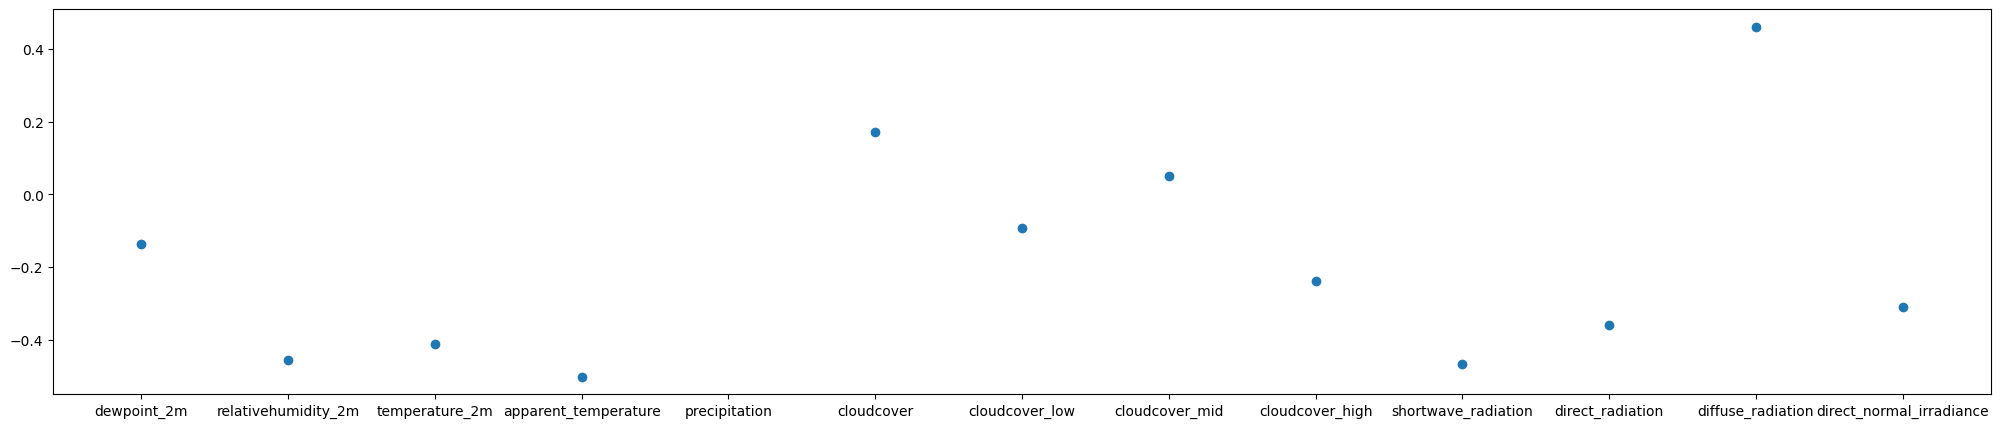

In [529]:
# plt.plot(range(22,29),daily_crps, label = 'crps', color = 'black')
corrs = []
for col in weather_cols:
  corrs.append(np.corrcoef(daily_crps, weather_dictionary[col])[0][1])
print(len(corrs), len(weather_cols))
plt.figure(figsize = (25,5))
plt.scatter(weather_cols,corrs)
plt.show()

<ipython-input-530-58bf7266af47>:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)


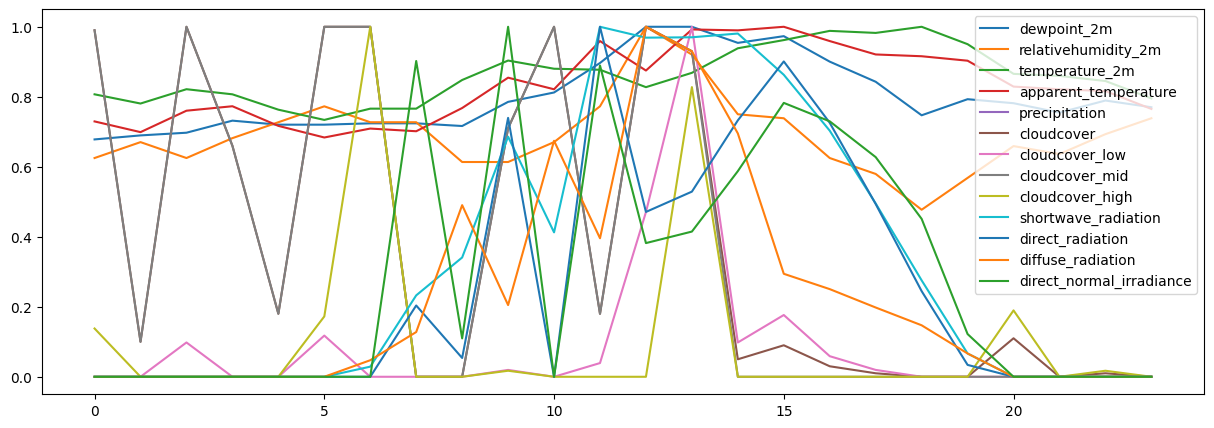

In [530]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

<ipython-input-531-62c645e8ea18>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)


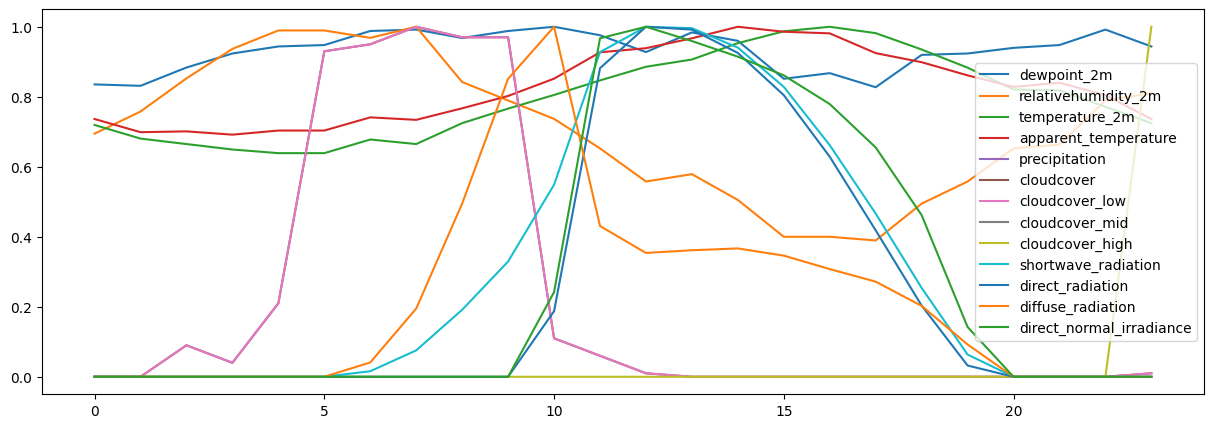

In [531]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [532]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [533]:
# from timezonefinder import TimezoneFinder
# states = {
#     'hi': {
#         "lat":21.446911,
#         "lon":-158.188736,
#         "fresh_data_time":'12',
#     },
#     'or': {
#         "lat":45.114559,
#         "lon":-123.204903,
#         "fresh_data_time":'12',
#     },
#     'tx': {
#         "lat":29.424122,
#         "lon":-98.493629,
#         "fresh_data_time":'06',
#     },
#     'ga': {
#         "lat":31.044241,
#         "lon":-84.879128,
#         "fresh_data_time":'06',
#     },

# }
# tf = TimezoneFinder(in_memory=True)
# for state in states:
#   local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
#   states[state]['local_time_zone'] = local_time_zone


# tx_lon = -98.493629
# tx_lat = 29.424122
# ga_lon = -84.879128
# ga_lat = 31.044241
# or_lon = -123.204903
# or_lat = 45.114559
# hi_lat = 21.446911
# hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return

In [534]:
test_data[-24-23:-23]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
408,2023-07-04 01:00:00,NaN,27.4,67,20.7,29.9,0.0,100,0,79,...,0.607769,0.617566,0.587540,0.581374,0.495447,0.497580,0.592324,0.614857,0.603216,0.590883
409,2023-07-04 02:00:00,NaN,26.6,74,21.5,30.2,0.0,100,1,29,...,0.542589,0.535039,0.524378,0.528181,0.464384,0.447672,0.536653,0.542416,0.538958,0.527259
410,2023-07-04 03:00:00,NaN,26.4,75,21.6,29.9,0.0,100,1,88,...,0.489050,0.486111,0.477582,0.478677,0.428250,0.426752,0.499424,0.481962,0.504841,0.485535
411,2023-07-04 04:00:00,NaN,26.1,76,21.5,29.7,0.0,100,0,88,...,0.459774,0.454933,0.449113,0.446577,0.410212,0.416090,0.457527,0.454242,0.481731,0.480233
412,2023-07-04 05:00:00,NaN,25.3,81,21.8,29.0,0.0,100,3,38,...,0.437990,0.439431,0.420067,0.407561,0.392174,0.410270,0.442312,0.442773,0.454703,0.439661
413,2023-07-04 06:00:00,NaN,24.9,84,22.0,28.6,0.0,100,10,100,...,0.438797,0.460754,0.404046,0.410270,0.393557,0.420067,0.448536,0.476314,0.436030,0.425945
414,2023-07-04 07:00:00,NaN,24.9,85,22.2,28.8,0.0,100,85,100,...,0.445424,0.430671,0.400184,0.397130,0.414477,0.406293,0.460120,0.484843,0.422833,0.424504
415,2023-07-04 08:00:00,NaN,25.6,84,22.7,29.6,0.0,100,29,100,...,0.444099,0.444214,0.402432,0.409578,0.402432,0.426810,0.457065,0.475622,0.433898,0.417704
416,2023-07-04 09:00:00,NaN,26.9,79,22.9,30.8,0.0,100,17,100,...,0.441217,0.440122,0.439892,0.455106,0.422487,0.426118,0.457181,0.460581,0.429115,0.428942
417,2023-07-04 10:00:00,NaN,28.9,69,22.6,32.6,0.0,100,18,100,...,0.452109,0.478562,0.468130,0.463405,0.452167,0.493545,0.477236,0.485362,0.474873,0.467727


In [535]:
test_df =  test_data[-23-24:-23].drop(columns = 'time')

In [536]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,1))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

In [537]:
test_data[-23-24:-23].

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16
408,2023-07-04 01:00:00,NaN,27.4,67,20.7,29.9,0.0,100,0,79,...,0.607769,0.617566,0.587540,0.581374,0.495447,0.497580,0.592324,0.614857,0.603216,0.590883
409,2023-07-04 02:00:00,NaN,26.6,74,21.5,30.2,0.0,100,1,29,...,0.542589,0.535039,0.524378,0.528181,0.464384,0.447672,0.536653,0.542416,0.538958,0.527259
410,2023-07-04 03:00:00,NaN,26.4,75,21.6,29.9,0.0,100,1,88,...,0.489050,0.486111,0.477582,0.478677,0.428250,0.426752,0.499424,0.481962,0.504841,0.485535
411,2023-07-04 04:00:00,NaN,26.1,76,21.5,29.7,0.0,100,0,88,...,0.459774,0.454933,0.449113,0.446577,0.410212,0.416090,0.457527,0.454242,0.481731,0.480233
412,2023-07-04 05:00:00,NaN,25.3,81,21.8,29.0,0.0,100,3,38,...,0.437990,0.439431,0.420067,0.407561,0.392174,0.410270,0.442312,0.442773,0.454703,0.439661
413,2023-07-04 06:00:00,NaN,24.9,84,22.0,28.6,0.0,100,10,100,...,0.438797,0.460754,0.404046,0.410270,0.393557,0.420067,0.448536,0.476314,0.436030,0.425945
414,2023-07-04 07:00:00,NaN,24.9,85,22.2,28.8,0.0,100,85,100,...,0.445424,0.430671,0.400184,0.397130,0.414477,0.406293,0.460120,0.484843,0.422833,0.424504
415,2023-07-04 08:00:00,NaN,25.6,84,22.7,29.6,0.0,100,29,100,...,0.444099,0.444214,0.402432,0.409578,0.402432,0.426810,0.457065,0.475622,0.433898,0.417704
416,2023-07-04 09:00:00,NaN,26.9,79,22.9,30.8,0.0,100,17,100,...,0.441217,0.440122,0.439892,0.455106,0.422487,0.426118,0.457181,0.460581,0.429115,0.428942
417,2023-07-04 10:00:00,NaN,28.9,69,22.6,32.6,0.0,100,18,100,...,0.452109,0.478562,0.468130,0.463405,0.452167,0.493545,0.477236,0.485362,0.474873,0.467727


In [542]:
std_hour

tensor([[0.0413],
        [0.0307],
        [0.0246],
        [0.0218],
        [0.0182],
        [0.0241],
        [0.0264],
        [0.0233],
        [0.0159],
        [0.0141],
        [0.0243],
        [0.0260],
        [0.0352],
        [0.0611],
        [0.0532],
        [0.0440],
        [0.0469],
        [0.0367],
        [0.0479],
        [0.0451],
        [0.0536],
        [0.0508],
        [0.0469],
        [0.0481]], dtype=torch.float64)

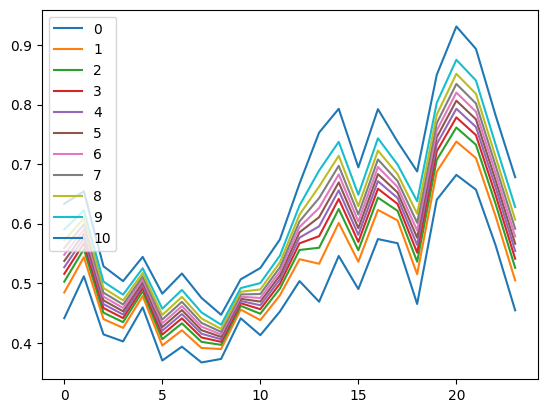

In [538]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df =  test_data[-23-24:-23].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
for i in range(0, 11):
  q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
  bias = mean_pred - mean_obs
  # corrected_mean = preds - bias#(preds - mean)


  pred2 = preds +  (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

  vals.append(pred2)
  plt.plot(pred2.detach().numpy(), label = str(i))

plt.legend()
plt.show()

pred = torch.concat(vals, dim = 1).detach().numpy()

# Submission Block

In [539]:
from datetime import datetime


In [540]:
# submission = pd.read_csv('')
# upload_function(submission.set_index('timestamp'),state_location)

In [541]:
# submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
# submission['timestamp'] = pd.date_range(start = '2023-07-04 01:00:00',
#                                          end =  '2023-07-05 00:00:00',
#                                          freq='H',
#                                          tz = states[state_location]['local_time_zone']
#                                          )
# submission[['p' + str(i*10) for i in range(11)]] = pred

# submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/hi_pytorch2_submission_{}.csv".format(datetime.now()))

# upload_function(submission.set_index('timestamp'),state_location)